In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, GlobalAveragePooling1D,
    GlobalMaxPooling1D, Multiply, Add, Activation, Lambda, Concatenate
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf

In [3]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [5]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [6]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix)
    testX, testy = load_dataset_group('test', prefix)
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [7]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset('/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [8]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [9]:
def cbam_block(input_tensor, ratio=8):
    # ----- Channel Attention -----
    channel_avg = GlobalAveragePooling1D()(input_tensor)
    channel_max = GlobalMaxPooling1D()(input_tensor)

    dense_avg = Dense(input_tensor.shape[-1]//ratio, activation='relu')(channel_avg)
    dense_avg = Dense(input_tensor.shape[-1], activation='sigmoid')(dense_avg)

    dense_max = Dense(input_tensor.shape[-1]//ratio, activation='relu')(channel_max)
    dense_max = Dense(input_tensor.shape[-1], activation='sigmoid')(dense_max)

    channel_attention = Add()([dense_avg, dense_max])
    channel_attention = Lambda(lambda x: tf.expand_dims(x, axis=1))(channel_attention)
    x = Multiply()([input_tensor, channel_attention])

    # ----- Spatial Attention -----
    spatial_avg = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    spatial_max = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    spatial = Concatenate(axis=-1)([spatial_avg, spatial_max])

    spatial_attention = Conv1D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial)
    x = Multiply()([x, spatial_attention])

    return x

In [10]:
inputs = Input(shape=(n_timesteps, n_features))
x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
x = cbam_block(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

cbam_model = Model(inputs, outputs)
cbam_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cbam_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 64)   │      1,792 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        520 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │        576 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │        576 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64)        │          0 │ dense_7[0][0],    │
│                     │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1, 64)     │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 128, 64)   │          0 │ conv1d_2[0][0],   │
│ (Multiply)          │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 128, 1)    │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 128, 1)    │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 2)    │          0 │ lambda_4[0][0],   │
│ (Concatenate)       │                   │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 1)    │         15 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 128, 64)   │          0 │ multiply_2[0][0], │
│ (Multiply)          │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8192)      │          0 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │  4,194,816 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 6)         │      3,078 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,201,893 (16.03 MB)

 Trainable params: 4,201,893 (16.03 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model_history = cbam_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.7379 - loss: 0.6548 - val_accuracy: 0.9202 - val_loss: 0.1889
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9236 - loss: 0.1929 - val_accuracy: 0.9321 - val_loss: 0.1864
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9489 - loss: 0.1248 - val_accuracy: 0.9440 - val_loss: 0.1518
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9495 - loss: 0.1170 - val_accuracy: 0.9372 - val_loss: 0.1319
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9555 - loss: 0.1028 - val_accuracy: 0.9423 - val_loss: 0.1368
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9583 - loss: 0.0979 - val_accuracy: 0.9457 - val_loss: 0.1264
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.9560 - loss: 0.1026 - val_accuracy: 0.9440 - val_loss: 0.1244
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9630 - loss: 0.0898 - 

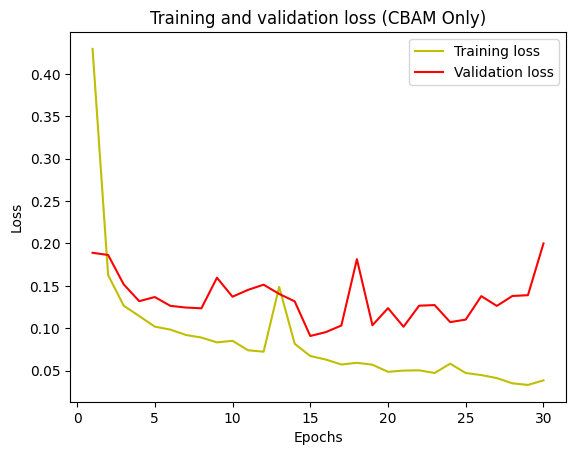

In [12]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (CBAM Only)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

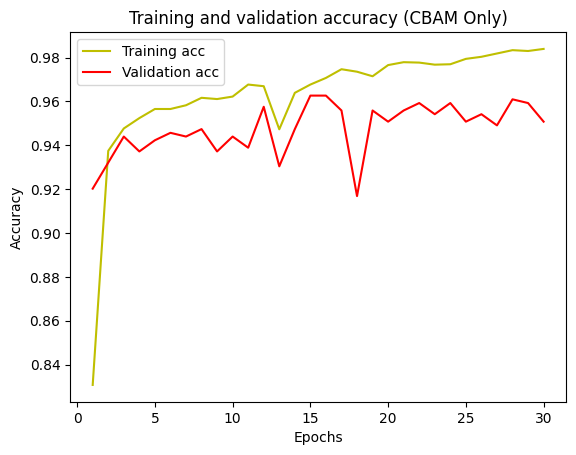

In [13]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (CBAM Only)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
[[412  36  46   2   0   0]
 [  2 435  34   0   0   0]
 [  5  21 394   0   0   0]
 [  0  26   0 402  63   0]
 [  0  11   0  96 425   0]
 [  0  27   0   0   0 510]]
0.8747879199185612
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       496
           1       0.78      0.92      0.85       471
           2       0.83      0.94      0.88       420
           3       0.80      0.82      0.81       491
           4       0.87      0.80      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.87      2947
   macro avg       0.88      0.88      0.87      2947
weighted avg       0.88      0.87      0.88      2947



<Axes: >

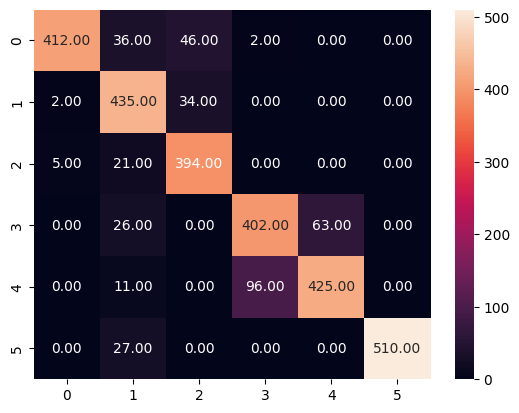

In [14]:
pred = cbam_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')